In [14]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

import pandas as pd, warnings
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

path_to_data_dir = "../../../data/"

def load_local_preprocessed_data():
	# X_train = pd.read_csv(path_to_data_dir + "prep_X_train.csv").set_index(["date", "ticker"])
	# X_val = pd.read_csv(path_to_data_dir + "prep_X_val.csv").set_index(["date", "ticker"])
	# X_test = pd.read_csv(path_to_data_dir + "prep_X_test.csv").set_index(["date", "ticker"])
	X_df = pd.read_csv(path_to_data_dir + "target_adjusted_features.csv").set_index(["date", "ticker"])
	target = pd.read_csv(path_to_data_dir + "s&p_adjusted_target.csv").set_index(["date", "ticker"])
	return X_df, target["change_adj_s&p"]

def split_date(all_dates, train_size = 0.75, days_ahead = 5):
	num_dates = len(all_dates)
	num_train_test_dates = num_dates - days_ahead
	num_train_dates = int(num_train_test_dates * train_size)

	train_dates = all_dates[:num_train_dates]
	val_dates = all_dates[num_train_dates:num_train_dates+days_ahead]
	test_dates = all_dates[num_train_dates+days_ahead:]

	return train_dates, val_dates, test_dates

In [15]:
# Load data
X_df, y_series = load_local_preprocessed_data()

train_dates, val_dates, test_dates = split_date(X_df.index.get_level_values(0).unique().sort_values()[2:])
print(f"# of train dates ({len(train_dates)}), val dates ({len(val_dates)}), test dates ({len(test_dates)})")

X_train, y_train = X_df.loc[train_dates], y_series.loc[train_dates]
X_val, y_val = X_df.loc[val_dates], y_series.loc[val_dates]
X_test, y_test = X_df.loc[test_dates], y_series.loc[test_dates]

print(f"Train shapes: {X_train.shape, y_train.shape}")
print(f"Val shapes: {X_val.shape, y_val.shape}")
print(f"Test shapes: {X_test.shape, y_test.shape}")

# of train dates (19), val dates (5), test dates (7)
Train shapes: ((29745, 339), (29745,))
Val shapes: ((7778, 339), (7778,))
Test shapes: ((11263, 339), (11263,))


In [16]:
# Preprocess
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

onehot_features = ["sector", "area"]
standard_scale_features = [f for f in X_train.columns.values if f not in onehot_features]

preprocessor = ColumnTransformer(
	transformers = [
		("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), onehot_features),
		("std", StandardScaler(), standard_scale_features)
	]
)

In [17]:
with open("xgb_cv_results_moving_window.json", "r") as cv_json:
	cv_results = json.load(cv_json)

In [18]:
latest_val_date = val_dates[-1]

model_params = {}
for model_name in cv_results:
	model_params[model_name] = cv_results[model_name]["best_params"][latest_val_date]

In [19]:
model_params

{'xgbregressor': {'xgbregressor__learning_rate': 0.001,
  'xgbregressor__max_depth': 5,
  'xgbregressor__n_estimators': 1000,
  'xgbregressor__reg_lambda': 1.0,
  'xgbregressor__subsample': 0.5}}

In [20]:
all_dates = np.array(train_dates.values.tolist() + val_dates.values.tolist() + test_dates.values.tolist())
len(all_dates), all_dates[0]

(31, '2023-10-02')

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

def evaluate_test_RMSE(X_all, y_all, train_dates, val_dates, test_dates, preprocessor, model_algo, params, moving_train_window = False, num_states = 5):
	all_dates = np.array(train_dates.values.tolist() + val_dates.values.tolist() + test_dates.values.tolist())

	random_states_train_rmse = defaultdict(lambda: dict())
	random_states_test_rmse = defaultdict(lambda: dict())

	all_train_preds = {}
	all_test_preds = {}

	all_train_rmse = {}
	all_test_rmse = {}

	all_train_r2 = {}
	all_test_r2 = {}
	
	all_train_std = {}
	all_test_std = {}

	print(f"Total dates: {len(all_dates)}")
	# Train latest best params for 7 test dates

	# Use time series split to prevent data leakage
	time_split = TimeSeriesSplit(n_splits=len(test_dates), test_size=1, gap=5)

	for i in range(num_states):

		pipe = make_pipeline(preprocessor, model_algo)
		if num_states > 1:
			pipe.set_params(**params, xgbregressor__random_state = i)
		else:
			pipe.set_params(**params)

		for train_idxs, test_idx in tqdm(time_split.split(all_dates), total = len(test_dates)):

			if moving_train_window:
					train_idxs = train_idxs[-10:]

			train_dates = all_dates[train_idxs]
			test_date = all_dates[test_idx]

			train_set_X = X_all.loc[train_dates]
			train_set_y = y_all.loc[train_dates]

			test_set_X = X_all.loc[test_date]
			test_set_y = y_all.loc[test_date]

			pipe.fit(train_set_X, train_set_y)

			truths = [train_set_y, test_set_y]

			preds = list(map(lambda v: pipe.predict(v), [train_set_X, test_set_X]))

			train_rmse, test_rmse = list(
				map(
					lambda x: mean_squared_error(x[0], x[1], squared=False),
					zip(truths, preds)))

			train_r2, test_r2 = list(
				map(
					lambda x: r2_score(x[0], x[1]),
					zip(truths, preds)))
			
			train_stddev, test_stddev = list(
				map(
					lambda pred: pred.std(),
					preds))
			
			# print(f"RMSE:")
			# print(f"Train: {train_rmse:.6f}")
			# print(f"Test: {test_rmse:.6f}")
			# print(f"R2:")
			# print(f"Train: {train_r2:.6f}")
			# print(f"Test: {test_r2:.6f}")
			# print(f"Stddev:")
			# print(f"Train: {train_stddev:.6f}")
			# print(f"Test: {test_stddev:.6f}")

			all_train_preds[test_date[0]], all_test_preds[test_date[0]] = preds
			all_train_rmse[test_date[0]], all_test_rmse[test_date[0]] = train_rmse, test_rmse
			all_train_r2[test_date[0]], all_test_r2[test_date[0]] = train_r2, test_r2
			all_train_std[test_date[0]], all_test_std[test_date[0]] = train_stddev, test_stddev
			random_states_train_rmse[i][test_date[0]] = train_rmse
			random_states_test_rmse[i][test_date[0]] = test_rmse

	return {
		"train_rmse": all_train_rmse,
		"test_rmse": all_test_rmse,
		"train_r2": all_train_r2,
		"test_r2": all_test_r2,
		"train_std": all_train_std,
		"test_std": all_test_std
	}, {"train": all_train_preds, "test": all_test_preds}, pipe, {"train": random_states_train_rmse, "test": random_states_test_rmse}


In [22]:
X_all = pd.concat([X_train, X_val, X_test], axis = 0)
y_all = pd.concat([y_train, y_val, y_test], axis = 0)
X_all.shape, y_all.shape

((48786, 339), (48786,))

In [23]:
model_params

{'xgbregressor': {'xgbregressor__learning_rate': 0.001,
  'xgbregressor__max_depth': 5,
  'xgbregressor__n_estimators': 1000,
  'xgbregressor__reg_lambda': 1.0,
  'xgbregressor__subsample': 0.5}}

In [24]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
# from sklearn.neighbors import KNeighborsRegressor
from xgboost.sklearn import XGBRegressor


models = [
	("xgbregressor", XGBRegressor()),
	# ("elasticnet", ElasticNet()),
	# ("bayesianridge", BayesianRidge()),
	# ("kneighborsregressor", KNeighborsRegressor()),
	# ("randomforestregressor", RandomForestRegressor()),
	# ("adaboostregressor", AdaBoostRegressor())
]

result_dfs = []
all_preds = {}
all_models = {}
random_states_results_all = {}

for model_name, model_algo in models:
	print(model_name)
	result_dict, model_preds, trained_model, random_states_results = evaluate_test_RMSE(
		X_all, y_all, train_dates, val_dates, test_dates, preprocessor,
		model_algo, model_params[model_name], moving_train_window=True)
	
	# Create result df and add to pile
	result_df = pd.DataFrame(result_dict).add_prefix(model_name + "_")
	result_dfs.append(result_df)
	all_preds[model_name] = model_preds
	all_models[model_name] = trained_model
	random_states_results_all[model_name] = random_states_results


xgbregressor
Total dates: 31


  0%|          | 0/7 [00:00<?, ?it/s]/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
 14%|█▍        | 1/7 [00:11<01:07, 11.21s/it]/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/nuowenlei/anaconda3/envs/Qua

In [25]:
train_random_states_df = pd.DataFrame(random_states_results_all["xgbregressor"]["train"])
test_random_states_df = pd.DataFrame(random_states_results_all["xgbregressor"]["test"])

In [26]:
def calc_mean_std_random_states(random_states_df):
	mean_ = random_states_df.mean(axis = 0)
	std_ = random_states_df.std(axis = 0)
	return pd.DataFrame({"mean": mean_, "std": std_})

In [29]:
test_mean_std_df = calc_mean_std_random_states(test_random_states_df.T)
test_mean_std_df

,mean,std
2023-11-06,0.065241,0.000039
2023-11-07,0.063601,0.000016
2023-11-08,0.056491,0.000050
2023-11-09,0.055549,0.000020
2023-11-10,0.057295,0.000026
2023-11-13,0.058574,0.000058
2023-11-14,0.080732,0.000047


In [36]:
test_random_states_df.to_csv("xgb_random_state_results.csv")

In [12]:
total_result_df = pd.concat(result_dfs, axis = 1)

In [13]:
# Get baseline results
moving_train_window = True

time_split = TimeSeriesSplit(n_splits=len(test_dates), test_size=1, gap=5)

all_dates = np.array(train_dates.tolist() + val_dates.tolist() + test_dates.tolist())

baseline_train_rmse_scores = {}
baseline_test_rmse_scores = {}
baseline_train_r2_scores = {}
baseline_test_r2_scores = {}
baseline_train_std_scores = {}
baseline_test_std_scores = {}

for train_idxs, test_idx in time_split.split(all_dates):
	
	if moving_train_window:
		train_idxs = train_idxs[-10:]

	train_dates = all_dates[train_idxs]
	test_date = all_dates[test_idx]

	train_set_X = X_all.loc[train_dates]
	train_set_y = y_all.loc[train_dates]

	test_set_X = X_all.loc[test_date]
	test_set_y = y_all.loc[test_date]

	baseline_pred = train_set_y.median()

	baseline_train_rmse = mean_squared_error(train_set_y.values, baseline_pred * np.ones_like(train_set_y.values), squared=False)
	baseline_test_rmse = mean_squared_error(test_set_y.values, baseline_pred * np.ones_like(test_set_y.values), squared=False)

	baseline_train_r2 = r2_score(train_set_y.values, baseline_pred * np.ones_like(train_set_y.values))
	baseline_test_r2 = r2_score(test_set_y.values, baseline_pred * np.ones_like(test_set_y.values))

	baseline_train_rmse_scores[test_date[0]], baseline_test_rmse_scores[test_date[0]] = baseline_train_rmse, baseline_test_rmse
	baseline_train_r2_scores[test_date[0]], baseline_test_r2_scores[test_date[0]] = baseline_train_r2, baseline_test_r2
	baseline_train_std_scores[test_date[0]], baseline_test_std_scores[test_date[0]] = 0.0, 0.0

baseline_results_df = pd.DataFrame({
		"train_rmse": baseline_train_rmse_scores,
		"test_rmse": baseline_test_rmse_scores,
		"train_r2": baseline_train_r2_scores,
		"test_r2": baseline_test_r2_scores,
		"train_std": baseline_train_std_scores,
		"test_std": baseline_test_std_scores
	})

In [14]:
total_result_df.mean(axis = 0)[total_result_df.columns[total_result_df.columns.str.contains("_test_rmse")]]

xgbregressor_test_rmse    0.06249
dtype: float64

In [15]:
total_result_df[total_result_df.columns[total_result_df.columns.str.contains("_test_rmse")]]

,xgbregressor_test_rmse
2023-11-06,0.065215
2023-11-07,0.063593
2023-11-08,0.056425
2023-11-09,0.055573
2023-11-10,0.057301
2023-11-13,0.058664
2023-11-14,0.080662


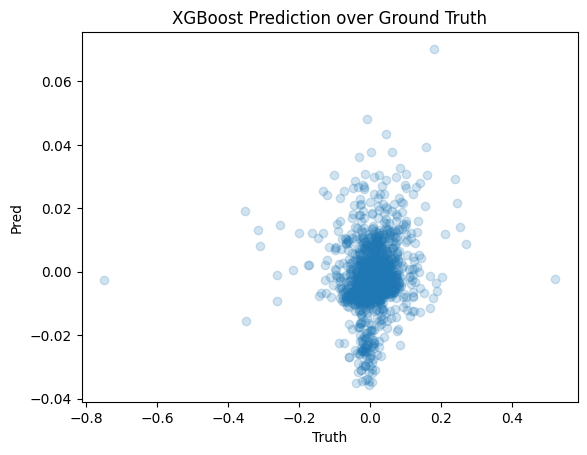

In [16]:
import matplotlib.pyplot as plt

plt.scatter(y_test.loc["2023-11-09"], all_preds["xgbregressor"]["test"]["2023-11-09"], alpha = 0.2)
plt.xlabel("Truth")
plt.ylabel("Pred")
plt.title("XGBoost Prediction over Ground Truth")
plt.savefig("xgb_pred_vs_truth.png", dpi = 300)

In [19]:
import shap
shap.initjs()

def make_global_and_local_shap_plots_linear(model_name, index = 0):
	explainer = shap.Explainer(all_models[model_name][0], train_set_X)
	shap_values = explainer.shap_values(test_set_X)
	shap.force_plot(
		explainer.expected_value,
		shap_values[index,:],
		features = np.around(test_set_X.iloc[index], decimals = 2),
		feature_names = test_set_X.columns,
		matplotlib = True)
	
	feature_names = test_set_X.columns
	top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
	shap_10_important_features = feature_names[top_10_important_ftr_indices]
	shap.summary_plot(
		shap_values[:, top_10_important_ftr_indices],
		test_set_X[shap_10_important_features],
		feature_names = shap_10_important_features)
	
def make_global_and_local_shap_plots_tree(model_name, index = 0):
	explainer = shap.TreeExplainer(all_models[model_name][0])
	shap_values = explainer.shap_values(test_set_X.iloc[index, :])
	shap.force_plot(
		explainer.expected_value,
		shap_values.reshape((1, -1)),
		features = np.around(test_set_X.iloc[index], decimals = 2),
		feature_names = test_set_X.columns,
		matplotlib = True)
	
	feature_names = test_set_X.columns
	top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
	shap_10_important_features = feature_names[top_10_important_ftr_indices]
	shap.summary_plot(
		shap_values[top_10_important_ftr_indices].reshape((1, -1)),
		test_set_X[shap_10_important_features],
		feature_names = shap_10_important_features)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


[00:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


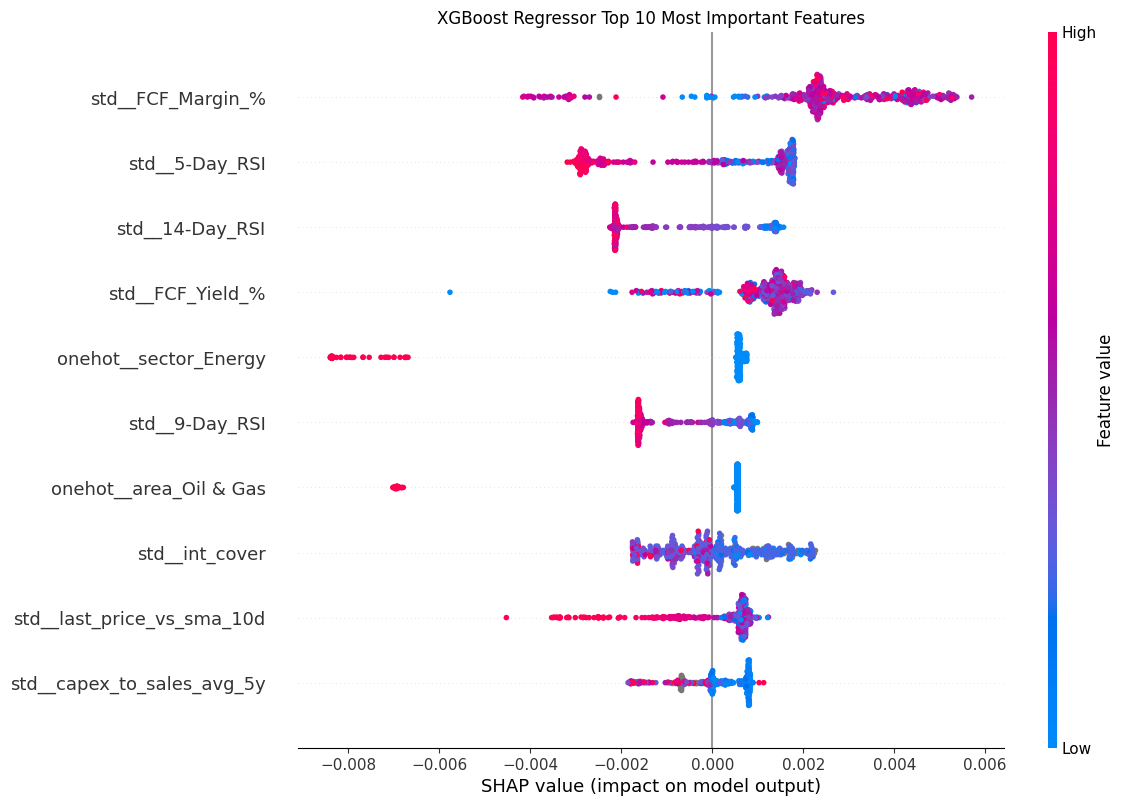

In [22]:
index = 0

preprocessor.fit(train_set_X)

preprocessed_test_set_X = preprocessor.transform(test_set_X)

preprocessed_test_set_X = pd.DataFrame(preprocessed_test_set_X, columns = preprocessor.get_feature_names_out())

explainer = shap.TreeExplainer(all_models["xgbregressor"][1])
shap.initjs()
shap_values = explainer.shap_values(preprocessed_test_set_X.iloc[index:(index+500), :], approximate=True)
# shap.force_plot(
# 	explainer.expected_value,
# 	shap_values,
# 	features = np.around(test_set_X.iloc[index], decimals = 2),
# 	feature_names = test_set_X.columns)

feature_names = preprocessed_test_set_X.columns
top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
shap_10_important_features = feature_names[top_10_important_ftr_indices]
shap.summary_plot(
	shap_values[:, top_10_important_ftr_indices],
	preprocessed_test_set_X.iloc[index:(index+500), :][shap_10_important_features],
	feature_names = shap_10_important_features, show = False, plot_size = (12, 8))
plt.title("XGBoost Regressor Top 10 Most Important Features")
plt.savefig("xgbregressor_shap.png", dpi = 300)

In [19]:
import shap

index = 0

preprocessor.fit(train_set_X)

preprocessed_test_set_X = preprocessor.transform(test_set_X)

preprocessed_test_set_X = pd.DataFrame(preprocessed_test_set_X, columns = preprocessor.get_feature_names_out())

explainer = shap.TreeExplainer(all_models["xgbregressor"][1])
shap.initjs()
shap_values = explainer.shap_values(preprocessed_test_set_X.iloc[index:(index+500), :], approximate=True)

[15:14:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


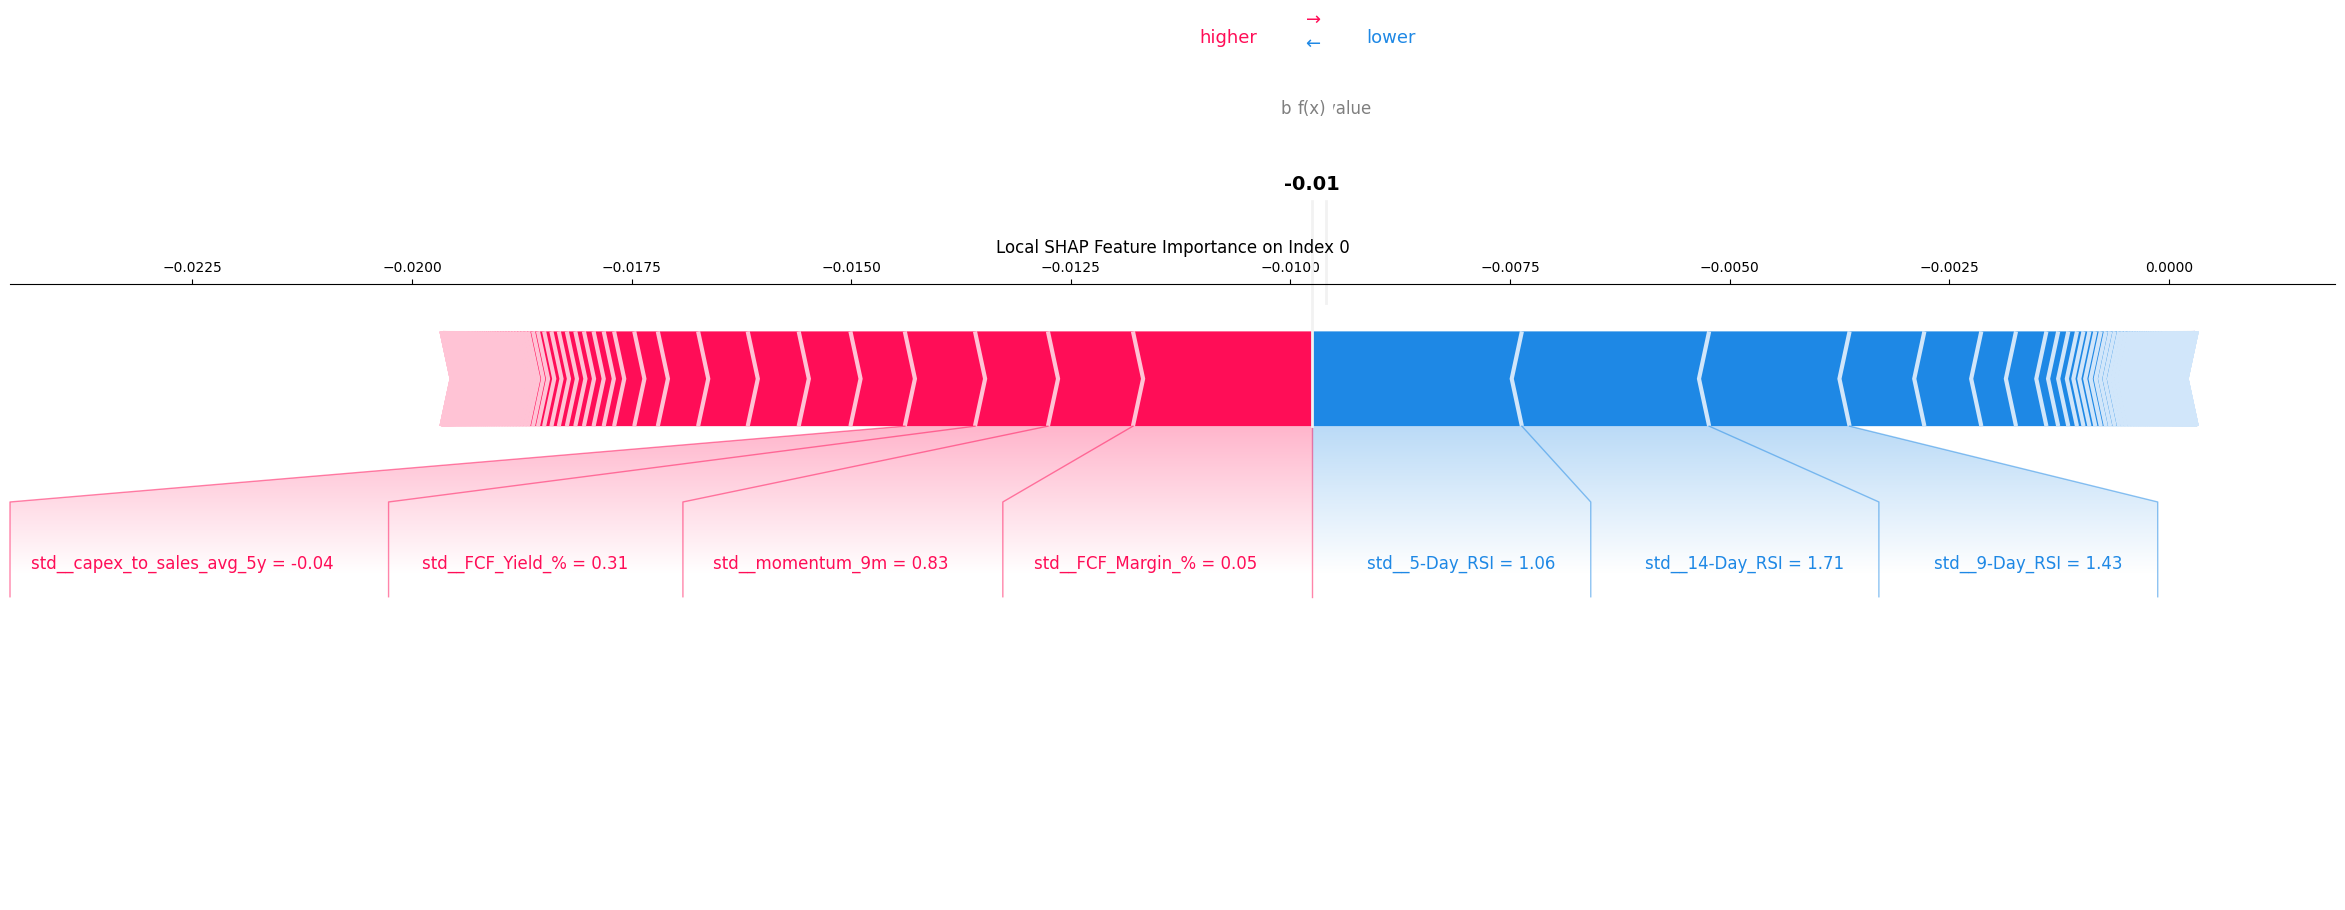

In [97]:
import matplotlib.pyplot as plt
index = 0
shap.force_plot(
	explainer.expected_value,
	shap_values[index, :],
	features = np.round(preprocessed_test_set_X.iloc[index], 2),
	feature_names = preprocessed_test_set_X.columns, matplotlib = True, show = False, figsize = (30, 8))
plt.title(f"Local SHAP Feature Importance on Index {index}")
plt.savefig("xgb_local.png", dpi=300)
plt.show()

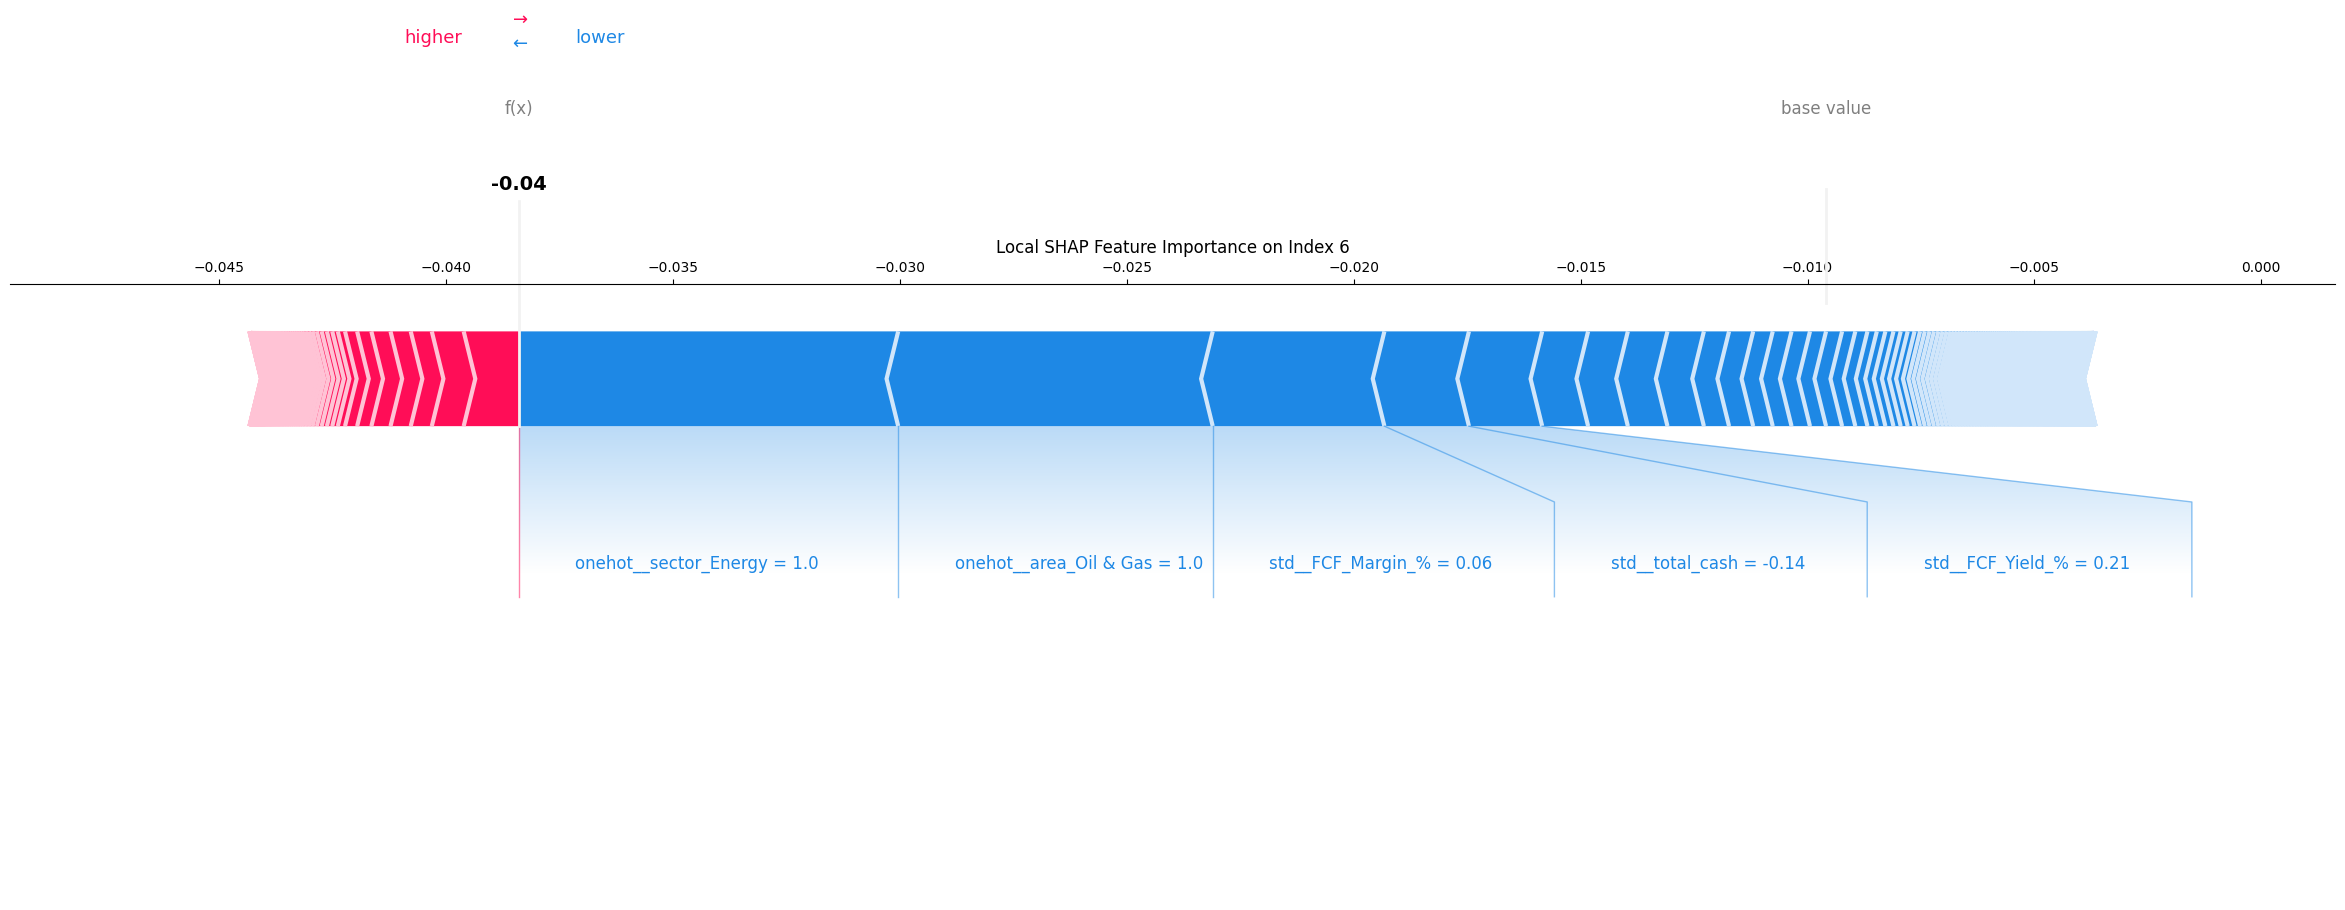

In [99]:
import matplotlib.pyplot as plt
index = 6
shap.force_plot(
	explainer.expected_value,
	shap_values[index, :],
	features = np.round(preprocessed_test_set_X.iloc[index], 2),
	feature_names = preprocessed_test_set_X.columns, matplotlib = True, show = False, figsize = (30, 8))
plt.title(f"Local SHAP Feature Importance on Index {index}")
plt.savefig("xgb_local_2.png", dpi=300)
plt.show()

In [37]:
booster = all_models["xgbregressor"][1].get_booster()

In [44]:
all_columns = preprocessed_test_set_X.columns

In [47]:
booster_scores = booster.get_score(importance_type="gain")
xgb_feature_importance = [(f, booster_scores[f"f{i}"]) for i, f in enumerate(all_columns) if f"f{i}" in booster_scores]

In [50]:
xgb_feature_importance = sorted(xgb_feature_importance, key = lambda x: x[1], reverse=True)

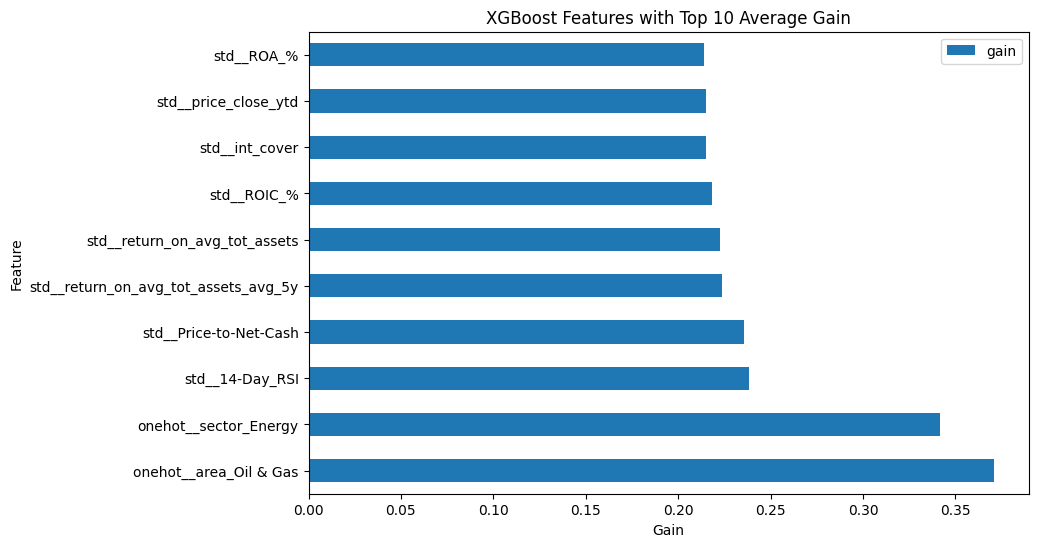

In [94]:
pd.DataFrame(xgb_feature_importance, columns = ["Feature", "gain"]).set_index("Feature").head(10).plot(kind="barh", figsize=(12, 6))
plt.title("XGBoost Features with Top 10 Average Gain")
plt.xlabel("Gain")
plt.subplots_adjust(left = 0.3)
plt.savefig("xgb_gain.png", dpi = 300)
plt.show()

In [100]:
from sklearn.inspection import permutation_importance

all_models["xgbregressor"][1]

perm = permutation_importance(all_models["xgbregressor"][1], preprocessed_test_set_X, test_set_y, scoring = "neg_root_mean_squared_error")

In [102]:
perm.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [38]:
total_result_df.median(axis = 0)

xgbregressor_train_rmse    0.057097
xgbregressor_test_rmse     0.058664
xgbregressor_train_r2      0.159039
xgbregressor_test_r2      -0.041238
xgbregressor_train_std     0.010183
xgbregressor_test_std      0.009239
dtype: float64

In [34]:
total_result_df.to_csv("xgbregressor_results.csv")

In [39]:
baseline_results_df.median(axis = 0)

train_rmse    0.062264
test_rmse     0.063803
train_r2     -0.000058
test_r2      -0.173157
train_std     0.000000
test_std      0.000000
dtype: float64

In [103]:
scores = perm["importances"]
ftr_names = preprocessed_test_set_X.columns.values
test_score = mean_squared_error(all_models["xgbregressor"][1].predict(preprocessed_test_set_X), test_set_y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


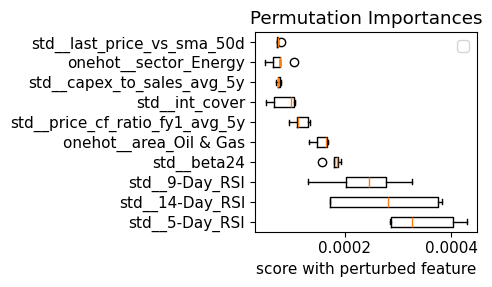

In [111]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
sorted_indcs = sorted_indcs[:10]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5,3))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
# plt.axvline(test_score,label='test score')
plt.title("Permutation Importances")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig("xgb_perm.png", dpi=300)
plt.show()